# Simulation using Concord

In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import numpy as np
import scanpy as sc
import time
from pathlib import Path
import torch
import concord as ccd
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import matplotlib as mpl

from matplotlib import font_manager, rcParams
custom_rc = {
    'font.family': 'Arial',  # Set the desired font for this plot
}

mpl.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['pdf.fonttype'] = 42

In [3]:
proj_name = "simulation_trajectory"
save_dir = f"../save/dev_{proj_name}-{time.strftime('%b%d')}/"
save_dir = Path(save_dir)
save_dir.mkdir(parents=True, exist_ok=True)

data_dir = f"../data/{proj_name}/"
data_dir = Path(data_dir)
data_dir.mkdir(parents=True, exist_ok=True)
device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')
print(device)
seed = 0
ccd.ul.set_seed(seed)

file_suffix = f"{time.strftime('%b%d-%H%M')}"
file_suffix

cpu


'Jun26-1434'

In [4]:
state_key = 'time'
batch_key = 'batch'
state_type = 'trajectory'
batch_type = 'batch_specific_features'
distribution = 'normal'
leiden_key = 'leiden_no_noise'

## Simulation

In [5]:
from concord.simulation import (
    Simulation,
    SimConfig,
    TrajectoryConfig,   # ← because state_type == 'trajectory'
    BatchConfig,
)

# ── 1. global simulation settings ──────────────────────────────────
sim_cfg = SimConfig(
    n_cells = 1_000,
    n_genes =   100,
    seed    =    42,
    non_neg =  True,
    to_int  =  True,
)

# ── 2. trajectory (state) settings ─────────────────────────────────
traj_cfg = TrajectoryConfig(
    # generic “state” parameters
    distribution   = "normal",   # ← state_distribution
    level          = 10,         # ← state_level
    min_level      = 0,          # ← state_min_level
    dispersion     = 2.0,        # ← state_dispersion

    # trajectory-specific knobs (copied 1-to-1)
    program_num            = 5,              # trajectory_program_num
    program_structure      = "linear_bidirectional",
    program_on_time_fraction = 0.1,
    cell_block_size_ratio  = 0.6,
    loop_to                = None,
)

# ── 3. batch settings ──────────────────────────────────────────────
batch_cfg = BatchConfig(
    n_batches    = 2,
    effect_type  = "batch_specific_features",    # batch_type
    distribution = "normal",                     # batch_distribution
    level        = [10, 10],                     # batch_level
    dispersion   = [2.0, 2.0],                   # batch_dispersion
    feature_frac = 0.1,                          # matches the old default
    # cell_proportion defaults to [0.5, 0.5] because n_batches = 2
)

# ── 4. run the simulation ──────────────────────────────────────────
sim   = Simulation(sim_cfg, traj_cfg, batch_cfg)
adata, adata_state = sim.simulate_data()

# keep the “counts” layer your downstream code expects
adata.layers["counts"] = adata.X.copy()


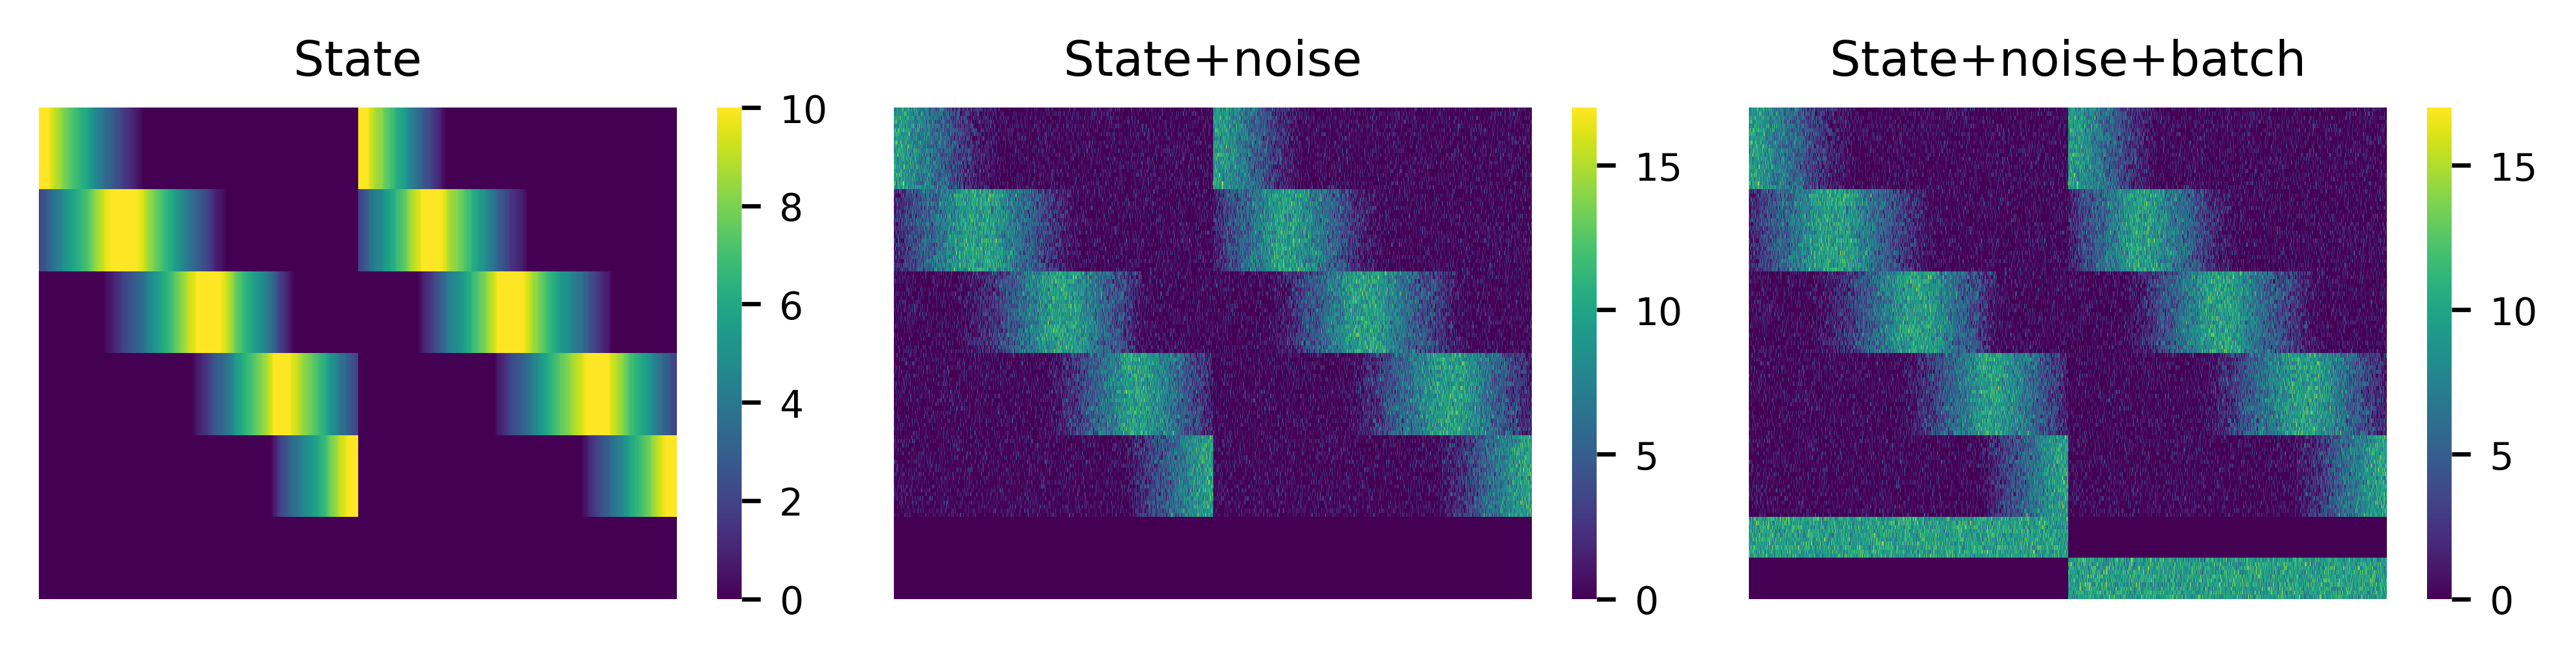

In [6]:
import matplotlib.pyplot as plt
figsize = (2.3, 1.8)
ncols = 3
title_fontsize = 9
dpi = 600
fig, axes = plt.subplots(1, ncols, figsize=(figsize[0] * ncols, figsize[1]), dpi=dpi)
ccd.pl.heatmap_with_annotations(adata, val='no_noise', obs_keys=[state_key], ax = axes[0], use_clustermap=False, yticklabels=False, cluster_cols=False, cluster_rows=False, value_annot=False, cmap='viridis', title='State', save_path=None, figsize=figsize, dpi=dpi, title_fontsize=title_fontsize)
ccd.pl.heatmap_with_annotations(adata, val='wt_noise', obs_keys=[state_key], ax = axes[1], use_clustermap=False, yticklabels=False, cluster_cols=False, cluster_rows=False, value_annot=False, cmap='viridis', title='State+noise', save_path=None, figsize=figsize, dpi=dpi, title_fontsize=title_fontsize)
ccd.pl.heatmap_with_annotations(adata, val='X', obs_keys=[state_key, batch_key], ax = axes[2], use_clustermap=False, yticklabels=False, cluster_cols=False, cluster_rows=False, value_annot=False, cmap='viridis', title='State+noise+batch', save_path=None, figsize=figsize, dpi=dpi, title_fontsize=title_fontsize)
plt.tight_layout(w_pad=0.0, h_pad=0.1)
plt.savefig(save_dir / f"data_heatmaps_{file_suffix}.svg", dpi=dpi, bbox_inches='tight')

## Integration pipeline

In [7]:
combined_keys = [
        "unintegrated",
        "scanorama", "liger", "harmony",
        "scvi", 
        "concord_knn", "concord_hcl", "contrastive"
    ]
latent_dim = 30

In [10]:

profile_logs = ccd.bm.run_integration_methods_pipeline(
    adata=adata,                          # Your input AnnData object
    methods=combined_keys,            # List of methods to run
    batch_key=batch_key,                    # Column in adata.obs for batch info
    count_layer="counts",                 # Layer name containing raw counts
    class_key=state_key,               # Column in adata.obs for class labels (used in SCANVI and CONCORD variants)
    latent_dim=latent_dim,                        # Latent dimensionality for PCA and embeddings
    device="cpu",                        # Or "cpu", or "mps" for Apple Silicon
    return_corrected=False,                   # Whether to store corrected expression matrices
    transform_batch=None,                 # Optionally specify a batch to transform to in scVI
    seed=42,                              # Random seed for reproducibility
    compute_umap=True,                        # Run UMAP for all output embeddings
    umap_n_components=2,
    umap_n_neighbors=30,
    umap_min_dist=0.5,
    verbose=True,                        # Print progress messages
)


Concord - INFO - Operating directly on the provided AnnData object. Object may be modified.
Concord - WARNING - save_dir is None. Model and log files will not be saved.
Concord - WARNING - Input data in adata.X appears to be raw counts. CONCORD performs best on normalized and log-transformed data. Consider setting normalize_total=True and log1p=True.
Concord - INFO - Setting sampler_knn to 100 to be 1/10 the number of cells in the dataset. You can change this value by setting sampler_knn in the configuration.
Concord - INFO - KNN sampling mode is enabled.
Concord - WARNING - No input feature list provided. It is recommended to first select features using the command `concord.ul.select_features()`.
Concord - INFO - Proceeding with all 120 features in the dataset.
Concord - INFO - Column 'batch' is already of type: category
Concord - INFO - Unused levels dropped for column 'batch'.
Concord - INFO - Encoder input dim: 120
Concord - INFO - Model loaded to device: cpu
Concord - INFO - Total

Epoch 0 Training: 100%|██████████| 14/14 [00:00<00:00, 317.07it/s, loss=3.75]

Concord - INFO - Epoch   0 | Train Loss: 4.00, MSE: 0.00, CLASS: 0.00, CONTRAST: 4.00, IMPORTANCE: 0.00
Concord - INFO - Starting epoch 2/10
Concord - INFO - Processing chunk 1/1 for epoch 2
Concord - INFO - Number of samples in train_dataloader: 1000



Epoch 1 Training: 100%|██████████| 14/14 [00:00<00:00, 348.22it/s, loss=3.73]

Concord - INFO - Epoch   1 | Train Loss: 3.74, MSE: 0.00, CLASS: 0.00, CONTRAST: 3.74, IMPORTANCE: 0.00
Concord - INFO - Starting epoch 3/10
Concord - INFO - Warm-up complete. Computing k-NN graph on learned embeddings.
Concord - INFO - Loading all data into memory.
Concord - INFO - Predicting for chunk 1/1
Concord - INFO - Loading all data into memory.



FAISS not found. Using sklearn for k-NN computation.


Concord - INFO - Processing chunk 1/1 for epoch 3
Concord - INFO - Number of samples in train_dataloader: 1000


Epoch 2 Training: 100%|██████████| 14/14 [00:00<00:00, 240.07it/s, loss=3.7]

Concord - INFO - Epoch   2 | Train Loss: 3.71, MSE: 0.00, CLASS: 0.00, CONTRAST: 3.71, IMPORTANCE: 0.00
Concord - INFO - Starting epoch 4/10
Concord - INFO - Processing chunk 1/1 for epoch 4
Concord - INFO - Number of samples in train_dataloader: 1000



Epoch 3 Training: 100%|██████████| 14/14 [00:00<00:00, 221.45it/s, loss=3.6]

Concord - INFO - Epoch   3 | Train Loss: 3.67, MSE: 0.00, CLASS: 0.00, CONTRAST: 3.67, IMPORTANCE: 0.00
Concord - INFO - Starting epoch 5/10
Concord - INFO - Processing chunk 1/1 for epoch 5
Concord - INFO - Number of samples in train_dataloader: 1000



Epoch 4 Training: 100%|██████████| 14/14 [00:00<00:00, 238.72it/s, loss=3.63]

Concord - INFO - Epoch   4 | Train Loss: 3.65, MSE: 0.00, CLASS: 0.00, CONTRAST: 3.65, IMPORTANCE: 0.00
Concord - INFO - Starting epoch 6/10
Concord - INFO - Processing chunk 1/1 for epoch 6
Concord - INFO - Number of samples in train_dataloader: 1000



Epoch 5 Training: 100%|██████████| 14/14 [00:00<00:00, 244.48it/s, loss=3.54]

Concord - INFO - Epoch   5 | Train Loss: 3.58, MSE: 0.00, CLASS: 0.00, CONTRAST: 3.58, IMPORTANCE: 0.00


Concord - INFO - Starting epoch 7/10
Concord - INFO - Processing chunk 1/1 for epoch 7
Concord - INFO - Number of samples in train_dataloader: 1000


Epoch 6 Training: 100%|██████████| 14/14 [00:00<00:00, 191.06it/s, loss=3.61]

Concord - INFO - Epoch   6 | Train Loss: 3.57, MSE: 0.00, CLASS: 0.00, CONTRAST: 3.57, IMPORTANCE: 0.00
Concord - INFO - Starting epoch 8/10
Concord - INFO - Processing chunk 1/1 for epoch 8
Concord - INFO - Number of samples in train_dataloader: 1000



Epoch 7 Training: 100%|██████████| 14/14 [00:00<00:00, 228.19it/s, loss=3.54]

Concord - INFO - Epoch   7 | Train Loss: 3.56, MSE: 0.00, CLASS: 0.00, CONTRAST: 3.56, IMPORTANCE: 0.00
Concord - INFO - Starting epoch 9/10
Concord - INFO - Processing chunk 1/1 for epoch 9
Concord - INFO - Number of samples in train_dataloader: 1000



Epoch 8 Training: 100%|██████████| 14/14 [00:00<00:00, 215.18it/s, loss=3.51]

Concord - INFO - Epoch   8 | Train Loss: 3.57, MSE: 0.00, CLASS: 0.00, CONTRAST: 3.57, IMPORTANCE: 0.00
Concord - INFO - Starting epoch 10/10
Concord - INFO - Processing chunk 1/1 for epoch 10
Concord - INFO - Number of samples in train_dataloader: 1000



Epoch 9 Training: 100%|██████████| 14/14 [00:00<00:00, 215.88it/s, loss=3.52]

Concord - INFO - Epoch   9 | Train Loss: 3.54, MSE: 0.00, CLASS: 0.00, CONTRAST: 3.54, IMPORTANCE: 0.00
Concord - WARNING - save_dir is None. Skipping model/config saving.
Concord - INFO - Loading all data into memory.


Concord - INFO - Predicting for chunk 1/1
Concord - INFO - Predictions added to AnnData object with base key 'concord_knn'.


concord_knn: 0.65s | 0.44 MB RAM | 0.00 MB VRAM
Running UMAP on concord_knn …


Concord - INFO - UMAP embedding stored in adata.obsm['concord_knn_UMAP']
Concord - INFO - Operating directly on the provided AnnData object. Object may be modified.
Concord - WARNING - save_dir is None. Model and log files will not be saved.
Concord - WARNING - Input data in adata.X appears to be raw counts. CONCORD performs best on normalized and log-transformed data. Consider setting normalize_total=True and log1p=True.
Concord - INFO - Using NT-Xent loss with beta=1.0. This will apply hard-negative weighting to the contrastive loss.
Concord - INFO - HCL (Contrastive learning with hard negative samples) mode is enabled.
Concord - WARNING - No input feature list provided. It is recommended to first select features using the command `concord.ul.select_features()`.
Concord - INFO - Proceeding with all 120 features in the dataset.
Concord - INFO - Column 'batch' is already of type: category
Concord - INFO - Unused levels dropped for column 'batch'.
Concord - INFO - Encoder input dim: 120

Epoch 0 Training: 100%|██████████| 14/14 [00:00<00:00, 266.24it/s, loss=4.32]

Concord - INFO - Epoch   0 | Train Loss: 4.40, MSE: 0.00, CLASS: 0.00, CONTRAST: 4.40, IMPORTANCE: 0.00
Concord - INFO - Starting epoch 2/10
Concord - INFO - Processing chunk 1/1 for epoch 2
Concord - INFO - Number of samples in train_dataloader: 1000



Epoch 1 Training: 100%|██████████| 14/14 [00:00<00:00, 268.01it/s, loss=4.33]

Concord - INFO - Epoch   1 | Train Loss: 4.32, MSE: 0.00, CLASS: 0.00, CONTRAST: 4.32, IMPORTANCE: 0.00
Concord - INFO - Starting epoch 3/10
Concord - INFO - Processing chunk 1/1 for epoch 3
Concord - INFO - Number of samples in train_dataloader: 1000



Epoch 2 Training: 100%|██████████| 14/14 [00:00<00:00, 266.54it/s, loss=4.29]

Concord - INFO - Epoch   2 | Train Loss: 4.30, MSE: 0.00, CLASS: 0.00, CONTRAST: 4.30, IMPORTANCE: 0.00
Concord - INFO - Starting epoch 4/10
Concord - INFO - Processing chunk 1/1 for epoch 4
Concord - INFO - Number of samples in train_dataloader: 1000



Epoch 3 Training: 100%|██████████| 14/14 [00:00<00:00, 240.32it/s, loss=4.23]

Concord - INFO - Epoch   3 | Train Loss: 4.26, MSE: 0.00, CLASS: 0.00, CONTRAST: 4.26, IMPORTANCE: 0.00
Concord - INFO - Starting epoch 5/10
Concord - INFO - Processing chunk 1/1 for epoch 5
Concord - INFO - Number of samples in train_dataloader: 1000



Epoch 4 Training: 100%|██████████| 14/14 [00:00<00:00, 284.08it/s, loss=4.28]

Concord - INFO - Epoch   4 | Train Loss: 4.25, MSE: 0.00, CLASS: 0.00, CONTRAST: 4.25, IMPORTANCE: 0.00
Concord - INFO - Starting epoch 6/10
Concord - INFO - Processing chunk 1/1 for epoch 6
Concord - INFO - Number of samples in train_dataloader: 1000



Epoch 5 Training: 100%|██████████| 14/14 [00:00<00:00, 289.49it/s, loss=4.23]

Concord - INFO - Epoch   5 | Train Loss: 4.25, MSE: 0.00, CLASS: 0.00, CONTRAST: 4.25, IMPORTANCE: 0.00
Concord - INFO - Starting epoch 7/10
Concord - INFO - Processing chunk 1/1 for epoch 7
Concord - INFO - Number of samples in train_dataloader: 1000



Epoch 6 Training: 100%|██████████| 14/14 [00:00<00:00, 289.33it/s, loss=4.24]

Concord - INFO - Epoch   6 | Train Loss: 4.23, MSE: 0.00, CLASS: 0.00, CONTRAST: 4.23, IMPORTANCE: 0.00
Concord - INFO - Starting epoch 8/10
Concord - INFO - Processing chunk 1/1 for epoch 8
Concord - INFO - Number of samples in train_dataloader: 1000



Epoch 7 Training: 100%|██████████| 14/14 [00:00<00:00, 230.93it/s, loss=4.21]

Concord - INFO - Epoch   7 | Train Loss: 4.23, MSE: 0.00, CLASS: 0.00, CONTRAST: 4.23, IMPORTANCE: 0.00
Concord - INFO - Starting epoch 9/10
Concord - INFO - Processing chunk 1/1 for epoch 9
Concord - INFO - Number of samples in train_dataloader: 1000



Epoch 8 Training: 100%|██████████| 14/14 [00:00<00:00, 276.57it/s, loss=4.25]

Concord - INFO - Epoch   8 | Train Loss: 4.22, MSE: 0.00, CLASS: 0.00, CONTRAST: 4.22, IMPORTANCE: 0.00
Concord - INFO - Starting epoch 10/10
Concord - INFO - Processing chunk 1/1 for epoch 10
Concord - INFO - Number of samples in train_dataloader: 1000



Epoch 9 Training: 100%|██████████| 14/14 [00:00<00:00, 281.61it/s, loss=4.22]

Concord - INFO - Epoch   9 | Train Loss: 4.21, MSE: 0.00, CLASS: 0.00, CONTRAST: 4.21, IMPORTANCE: 0.00
Concord - WARNING - save_dir is None. Skipping model/config saving.
Concord - INFO - Loading all data into memory.


Concord - INFO - Predicting for chunk 1/1
Concord - INFO - Predictions added to AnnData object with base key 'concord_hcl'.


concord_hcl: 0.56s | 0.50 MB RAM | 0.00 MB VRAM
Running UMAP on concord_hcl …


Concord - INFO - UMAP embedding stored in adata.obsm['concord_hcl_UMAP']
Concord - INFO - Operating directly on the provided AnnData object. Object may be modified.
Concord - WARNING - save_dir is None. Model and log files will not be saved.
Concord - WARNING - Input data in adata.X appears to be raw counts. CONCORD performs best on normalized and log-transformed data. Consider setting normalize_total=True and log1p=True.
Concord - WARNING - No input feature list provided. It is recommended to first select features using the command `concord.ul.select_features()`.
Concord - INFO - Proceeding with all 120 features in the dataset.
Concord - WARNING - domain/batch information not found, all samples will be treated as from single domain/batch.
Concord - WARNING - Only one domain found in the data. Setting p_intra_domain to 1.0.
Concord - INFO - Encoder input dim: 120
Concord - INFO - Model loaded to device: cpu
Concord - INFO - Total number of parameters: 78434
Concord - INFO - Loading all

Epoch 0 Training: 100%|██████████| 15/15 [00:00<00:00, 335.85it/s, loss=3.62]

Concord - INFO - Epoch   0 | Train Loss: 3.87, MSE: 0.00, CLASS: 0.00, CONTRAST: 3.87, IMPORTANCE: 0.00
Concord - INFO - Starting epoch 2/10
Concord - INFO - Processing chunk 1/1 for epoch 2
Concord - INFO - Number of samples in train_dataloader: 1000



Epoch 1 Training: 100%|██████████| 15/15 [00:00<00:00, 348.28it/s, loss=3.53]

Concord - INFO - Epoch   1 | Train Loss: 3.59, MSE: 0.00, CLASS: 0.00, CONTRAST: 3.59, IMPORTANCE: 0.00
Concord - INFO - Starting epoch 3/10
Concord - INFO - Processing chunk 1/1 for epoch 3
Concord - INFO - Number of samples in train_dataloader: 1000



Epoch 2 Training: 100%|██████████| 15/15 [00:00<00:00, 340.89it/s, loss=3.43]

Concord - INFO - Epoch   2 | Train Loss: 3.47, MSE: 0.00, CLASS: 0.00, CONTRAST: 3.47, IMPORTANCE: 0.00
Concord - INFO - Starting epoch 4/10
Concord - INFO - Processing chunk 1/1 for epoch 4
Concord - INFO - Number of samples in train_dataloader: 1000



Epoch 3 Training: 100%|██████████| 15/15 [00:00<00:00, 311.26it/s, loss=3.36]

Concord - INFO - Epoch   3 | Train Loss: 3.38, MSE: 0.00, CLASS: 0.00, CONTRAST: 3.38, IMPORTANCE: 0.00
Concord - INFO - Starting epoch 5/10
Concord - INFO - Processing chunk 1/1 for epoch 5
Concord - INFO - Number of samples in train_dataloader: 1000



Epoch 4 Training: 100%|██████████| 15/15 [00:00<00:00, 311.73it/s, loss=3.39]

Concord - INFO - Epoch   4 | Train Loss: 3.35, MSE: 0.00, CLASS: 0.00, CONTRAST: 3.35, IMPORTANCE: 0.00
Concord - INFO - Starting epoch 6/10


Concord - INFO - Processing chunk 1/1 for epoch 6
Concord - INFO - Number of samples in train_dataloader: 1000


Epoch 5 Training: 100%|██████████| 15/15 [00:00<00:00, 302.92it/s, loss=3.33]

Concord - INFO - Epoch   5 | Train Loss: 3.32, MSE: 0.00, CLASS: 0.00, CONTRAST: 3.32, IMPORTANCE: 0.00


Concord - INFO - Starting epoch 7/10
Concord - INFO - Processing chunk 1/1 for epoch 7
Concord - INFO - Number of samples in train_dataloader: 1000


Epoch 6 Training: 100%|██████████| 15/15 [00:00<00:00, 269.92it/s, loss=3.27]

Concord - INFO - Epoch   6 | Train Loss: 3.30, MSE: 0.00, CLASS: 0.00, CONTRAST: 3.30, IMPORTANCE: 0.00
Concord - INFO - Starting epoch 8/10
Concord - INFO - Processing chunk 1/1 for epoch 8
Concord - INFO - Number of samples in train_dataloader: 1000



Epoch 7 Training: 100%|██████████| 15/15 [00:00<00:00, 306.74it/s, loss=3.24]

Concord - INFO - Epoch   7 | Train Loss: 3.28, MSE: 0.00, CLASS: 0.00, CONTRAST: 3.28, IMPORTANCE: 0.00
Concord - INFO - Starting epoch 9/10
Concord - INFO - Processing chunk 1/1 for epoch 9
Concord - INFO - Number of samples in train_dataloader: 1000



Epoch 8 Training: 100%|██████████| 15/15 [00:00<00:00, 310.58it/s, loss=3.28]

Concord - INFO - Epoch   8 | Train Loss: 3.29, MSE: 0.00, CLASS: 0.00, CONTRAST: 3.29, IMPORTANCE: 0.00
Concord - INFO - Starting epoch 10/10
Concord - INFO - Processing chunk 1/1 for epoch 10
Concord - INFO - Number of samples in train_dataloader: 1000



Epoch 9 Training: 100%|██████████| 15/15 [00:00<00:00, 306.68it/s, loss=3.32]

Concord - INFO - Epoch   9 | Train Loss: 3.28, MSE: 0.00, CLASS: 0.00, CONTRAST: 3.28, IMPORTANCE: 0.00
Concord - WARNING - save_dir is None. Skipping model/config saving.


Concord - INFO - Loading all data into memory.
Concord - INFO - Predicting for chunk 1/1
Concord - INFO - Predictions added to AnnData object with base key 'contrastive'.


contrastive: 0.52s | 0.05 MB RAM | 0.00 MB VRAM
Running UMAP on contrastive …


Concord - INFO - UMAP embedding stored in adata.obsm['contrastive_UMAP']


Running UMAP on unintegrated …


Concord - INFO - UMAP embedding stored in adata.obsm['unintegrated_UMAP']
Found 120 genes among all datasets
[[0.    0.002]
 [0.    0.   ]]


scanorama: 0.02s | 0.03 MB RAM | 0.00 MB VRAM
Running UMAP on scanorama …


Concord - INFO - UMAP embedding stored in adata.obsm['scanorama_UMAP']


100%|██████████| 30/30 [00:01<00:00, 21.11it/s]
liger: 1.46s | 13.09 MB RAM | 0.00 MB VRAM
Running UMAP on liger …


Concord - INFO - UMAP embedding stored in adata.obsm['liger_UMAP']
	Initialization is completed.
	Completed 1 / 10 iteration(s).
	Completed 2 / 10 iteration(s).
	Completed 3 / 10 iteration(s).
	Completed 4 / 10 iteration(s).
	Completed 5 / 10 iteration(s).
	Completed 6 / 10 iteration(s).
	Completed 7 / 10 iteration(s).
	Completed 8 / 10 iteration(s).
	Completed 9 / 10 iteration(s).
	Completed 10 / 10 iteration(s).


harmony: 0.66s | 0.00 MB RAM | 0.00 MB VRAM
Running UMAP on harmony …


Concord - INFO - UMAP embedding stored in adata.obsm['harmony_UMAP']


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Training:   0%|          | 0/400 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=400` reached.
scvi: 17.64s | 0.78 MB RAM | 0.00 MB VRAM
Running UMAP on scvi …


Concord - INFO - UMAP embedding stored in adata.obsm['scvi_UMAP']


✅ All selected methods completed.


In [11]:
profile_logs

time_sec     ram_MB  vram_MB
concord_hcl   0.561475   0.500000      0.0
concord_knn   0.649982   0.437500      0.0
contrastive   0.519001   0.046875      0.0
harmony       0.663186   0.000000      0.0
liger         1.462570  13.093750      0.0
scanorama     0.015090   0.031250      0.0
scvi         17.644518   0.781250      0.0

In [12]:
# Add ground truth
ccd.ul.run_pca(adata_state, source_key='no_noise', result_key='PCA_no_noise', n_pc=latent_dim, random_state=seed)
ccd.ul.run_pca(adata_state, source_key='wt_noise', result_key='PCA_wt_noise', n_pc=latent_dim, random_state=seed)
# Put the PCA result in the adata object, so only one object is needed
adata.obsm['no_noise'] = adata_state.obsm['PCA_no_noise']
adata.obsm['wt_noise'] = adata_state.obsm['PCA_wt_noise']
ccd.ul.run_umap(adata, source_key='no_noise', result_key='no_noise_UMAP', n_components=2, random_state=seed)
ccd.ul.run_umap(adata, source_key='wt_noise', result_key='wt_noise_UMAP', n_components=2, random_state=seed)
adata.obsm

Concord - INFO - PCA performed on source data with 30 components
Concord - INFO - PCA embedding stored in adata.obsm['PCA_no_noise']
Concord - INFO - PCA performed on source data with 30 components
Concord - INFO - PCA embedding stored in adata.obsm['PCA_wt_noise']
Concord - INFO - UMAP embedding stored in adata.obsm['no_noise_UMAP']
Concord - INFO - UMAP embedding stored in adata.obsm['wt_noise_UMAP']


AxisArrays with keys: X_concord_warmup, concord_knn, concord_knn_UMAP, concord_hcl, concord_hcl_UMAP, contrastive, contrastive_UMAP, X_pca, unintegrated, unintegrated_UMAP, scanorama, scanorama_UMAP, liger, liger_UMAP, harmony, harmony_UMAP, scvi, scvi_UMAP, no_noise, wt_noise, no_noise_UMAP, wt_noise_UMAP

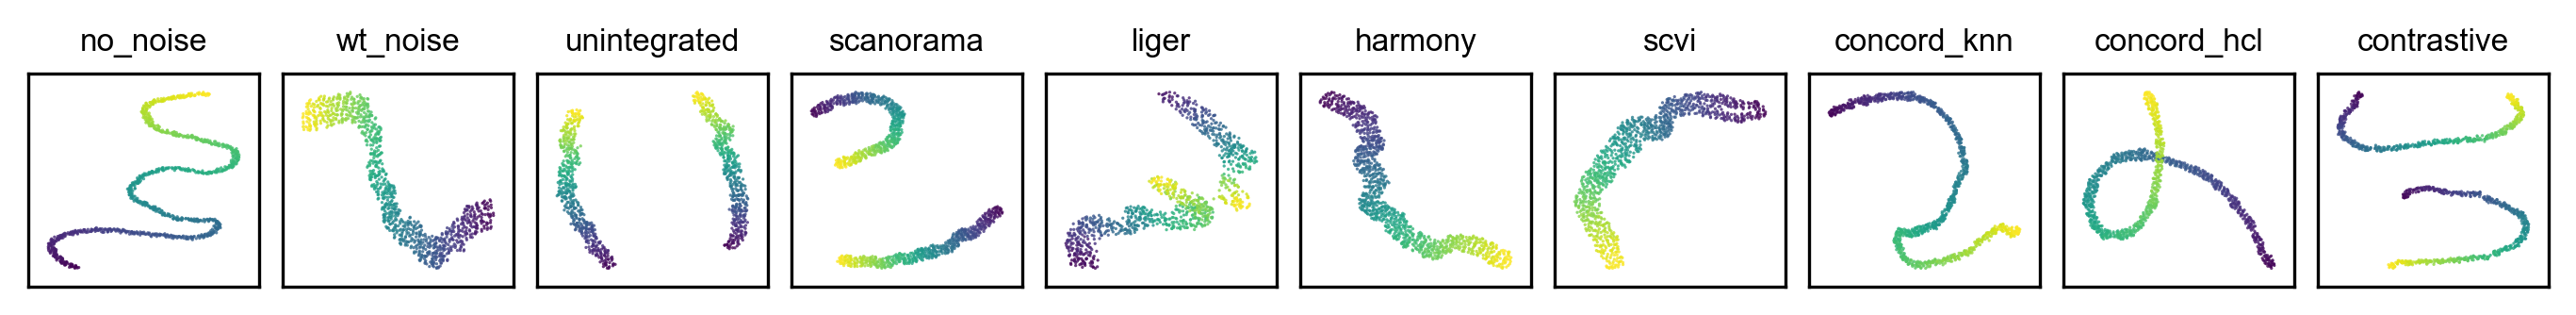

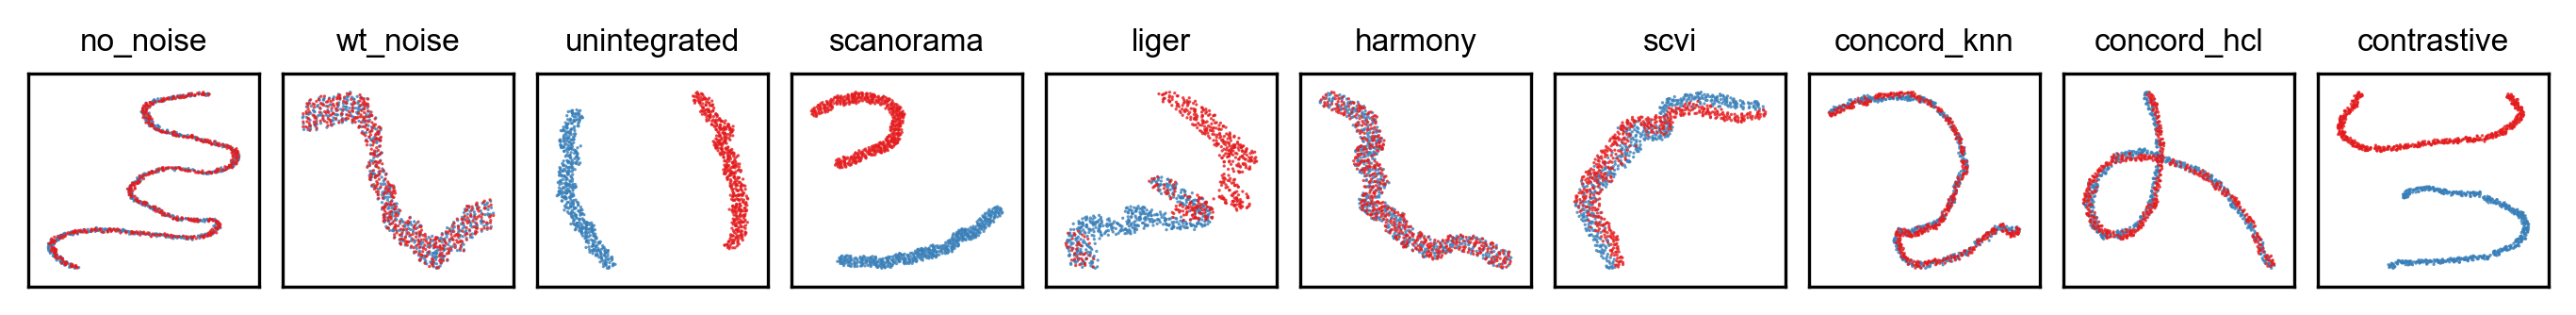

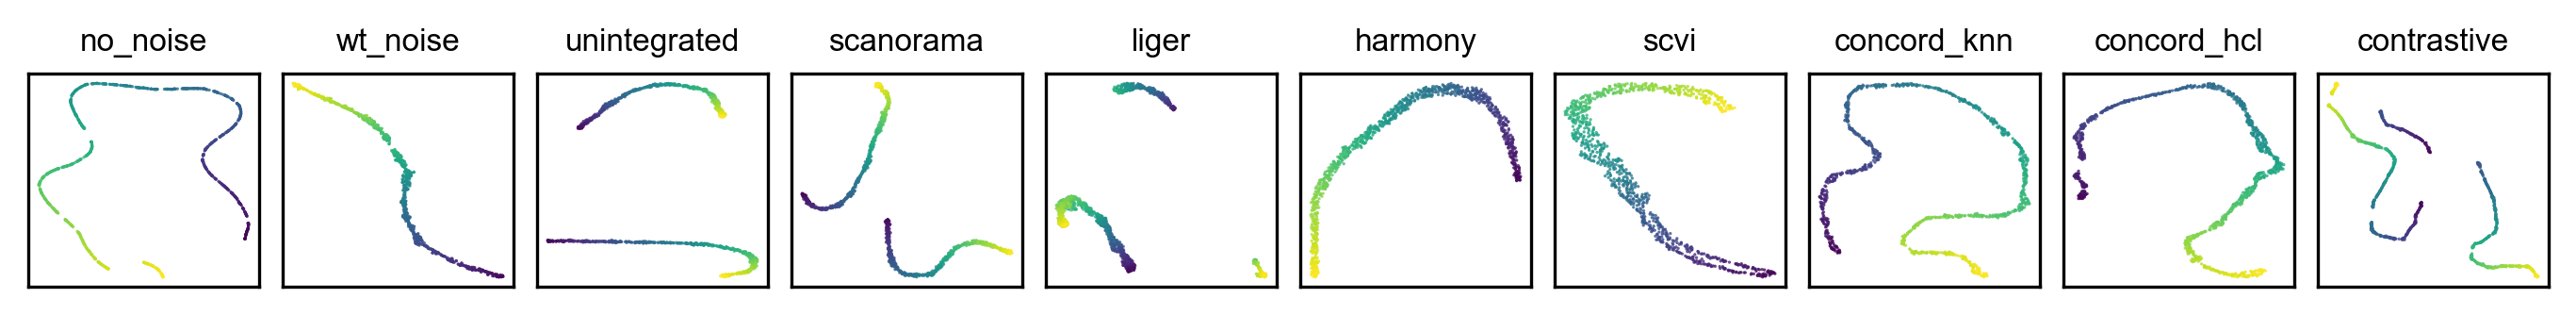

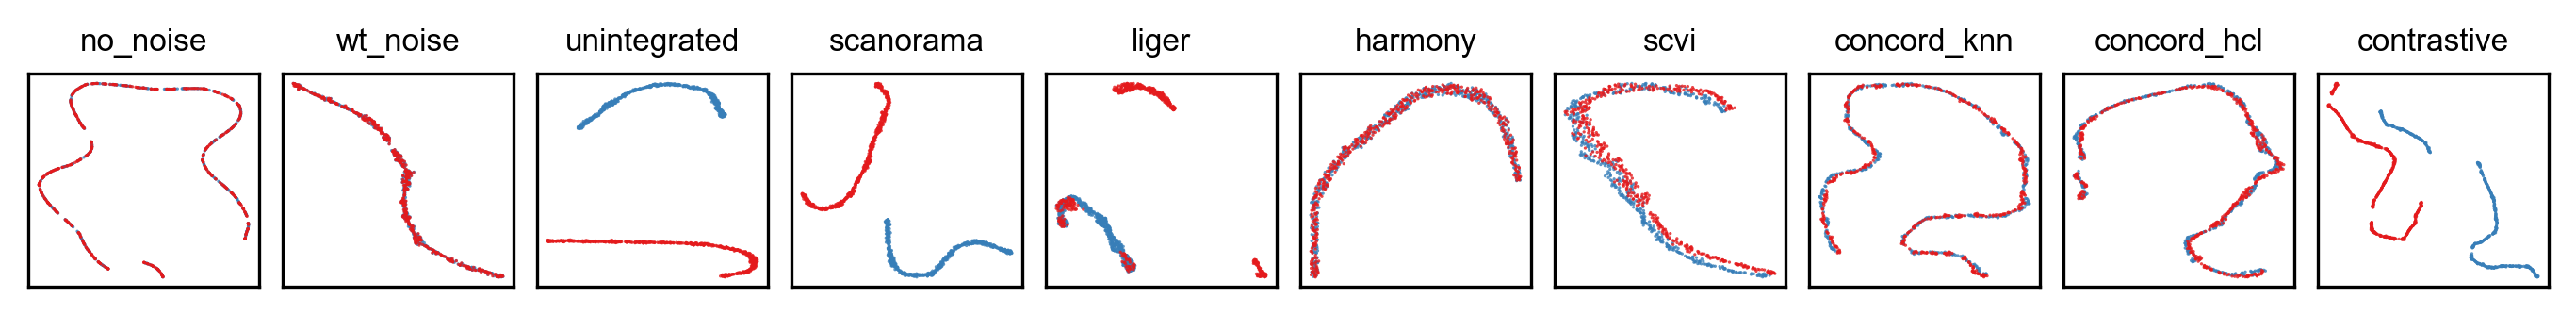

In [13]:
# plot everything
import matplotlib.pyplot as plt

show_keys = ['no_noise', 'wt_noise'] + [key for key in combined_keys if key in adata.obsm.keys()]
# check which methods are run successfully
adata.obs['time'] = adata.obs['time'].astype(float)
color_bys = ['time', 'batch']
basis_types = ['KNN', 'UMAP']
#basis_types = ['PCA']
font_size=8
point_size=2.5
alpha=0.8
figsize=(0.9*len(show_keys),1)
ncols = len(show_keys)
nrows = int(np.ceil(len(show_keys) / ncols))
pal = {'time':'viridis', 'batch':'Set1'}
k=15
edges_color='grey'
edges_width=0
layout='kk'
threshold = 0.1
node_size_scale=0.1
edge_width_scale=0.1

rasterized = True
with plt.rc_context(rc=custom_rc):
    ccd.pl.plot_all_embeddings(
        adata,
        show_keys,
        color_bys=color_bys,
        basis_types=basis_types,
        pal=pal,
        k=k,
        edges_color=edges_color,
        edges_width=edges_width,
        layout=layout,
        threshold=threshold,
        node_size_scale=node_size_scale,
        edge_width_scale=edge_width_scale,
        font_size=font_size,
        point_size=point_size,
        alpha=alpha,
        rasterized=rasterized,
        figsize=figsize,
        ncols=ncols,
        seed=seed,
        leiden_key='leiden',
        save_dir=save_dir,
        file_suffix=file_suffix+f'rasterized_{rasterized}',
        save_format='svg'
    )


In [14]:
adata.layers['no_noise'] = np.zeros_like(adata.X)
adata.layers['wt_noise'] = np.zeros_like(adata.X)
# Find the indices of common genes between `adata` and `adata_state`
common_genes = adata.var_names.intersection(adata_state.var_names)
adata_indices = adata.var_names.get_indexer(common_genes)
adata_state_indices = adata_state.var_names.get_indexer(common_genes)

# Copy data from `adata_state` to `adata` for these common genes
adata.layers['no_noise'][:, adata_indices] = adata_state.layers['no_noise'][:, adata_state_indices].copy()
adata.layers['wt_noise'][:, adata_indices] = adata_state.layers['wt_noise'][:, adata_state_indices].copy()

# sort and smooth the signal along the path
batch_id=adata.obs['batch'].unique()[0]
batch_indices = np.where(adata.obs['batch'] == batch_id)[0]
_, _, _, feature_order = ccd.ul.sort_and_smooth_signal_along_path(adata, signal_key='concord_knn', path=batch_indices, sigma=2)
adata.obsm['concord_knn_sorted'] = adata.obsm['concord_knn'][:, feature_order]
_, _, _, feature_order = ccd.ul.sort_and_smooth_signal_along_path(adata, signal_key='concord_hcl', path=batch_indices, sigma=2)
adata.obsm['concord_hcl_sorted'] = adata.obsm['concord_hcl'][:, feature_order]


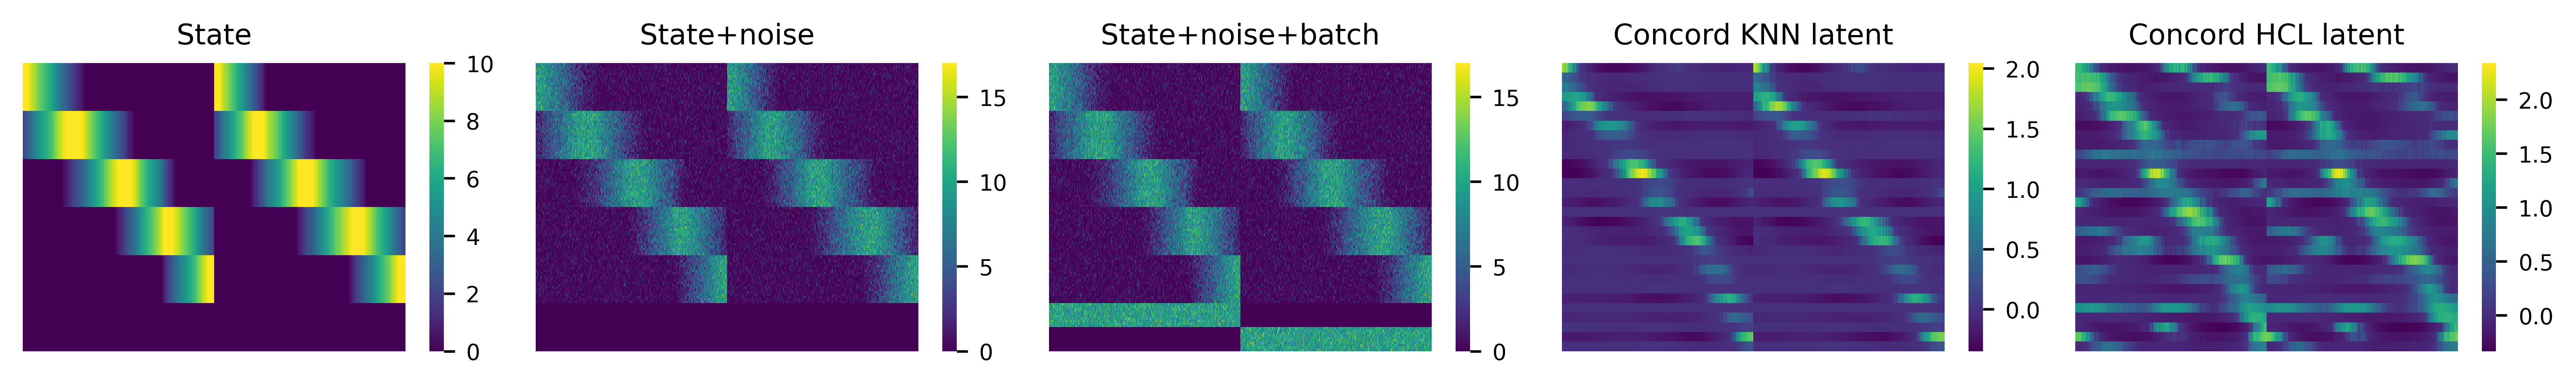

In [15]:
# Plot heatmap of original data and Concord latent
import matplotlib.pyplot as plt
figsize = (2.3, 1.8)
ncols = 5
title_fontsize = 9
dpi = 600
fig, axes = plt.subplots(1, ncols, figsize=(figsize[0] * ncols, figsize[1]), dpi=dpi)
ccd.pl.heatmap_with_annotations(adata, val='no_noise', obs_keys=[state_key], ax = axes[0], use_clustermap=False, yticklabels=False, cluster_cols=False, cluster_rows=False, value_annot=False, cmap='viridis', title='State', save_path=None, figsize=figsize, dpi=dpi, title_fontsize=title_fontsize)
ccd.pl.heatmap_with_annotations(adata, val='wt_noise', obs_keys=[state_key], ax = axes[1], use_clustermap=False, yticklabels=False, cluster_cols=False, cluster_rows=False, value_annot=False, cmap='viridis', title='State+noise', save_path=None, figsize=figsize, dpi=dpi, title_fontsize=title_fontsize)
ccd.pl.heatmap_with_annotations(adata, val='X', obs_keys=[state_key, batch_key], ax = axes[2], use_clustermap=False, yticklabels=False, cluster_cols=False, cluster_rows=False, value_annot=False, cmap='viridis', title='State+noise+batch', save_path=None, figsize=figsize, dpi=dpi, title_fontsize=title_fontsize)
ccd.pl.heatmap_with_annotations(adata, val='concord_knn_sorted', obs_keys=[state_key, batch_key], ax = axes[3], use_clustermap=False, yticklabels=False, cluster_cols=False, cluster_rows=False, value_annot=False, cmap='viridis', title='Concord KNN latent', save_path=None, figsize=figsize, dpi=dpi, title_fontsize=title_fontsize)
ccd.pl.heatmap_with_annotations(adata, val='concord_hcl_sorted', obs_keys=[state_key, batch_key], ax = axes[4], use_clustermap=False, yticklabels=False, cluster_cols=False, cluster_rows=False, value_annot=False, cmap='viridis', title='Concord HCL latent', save_path=None, figsize=figsize, dpi=dpi, title_fontsize=title_fontsize)
plt.tight_layout(w_pad=0.0, h_pad=0.1)
plt.savefig(save_dir / f"all_heatmaps_{file_suffix}.svg", dpi=dpi, bbox_inches='tight')

In [16]:
# Save result
adata.write_h5ad(data_dir / f"adata_{file_suffix}.h5ad", compression='gzip')
adata_state.write_h5ad(data_dir / f"adata_state_{file_suffix}.h5ad", compression='gzip')
print(f"Saved adata to {data_dir / f'adata_{file_suffix}.h5ad'}")
print(f"Saved adata_state to {data_dir / f'adata_state_{file_suffix}.h5ad'}")

Saved adata to ../data/simulation_trajectory/adata_Jun26-1434.h5ad
Saved adata_state to ../data/simulation_trajectory/adata_state_Jun26-1434.h5ad


In [21]:
profile_logs

time_sec     ram_MB  vram_MB
concord_hcl   0.561475   0.500000      0.0
concord_knn   0.649982   0.437500      0.0
contrastive   0.519001   0.046875      0.0
harmony       0.663186   0.000000      0.0
liger         1.462570  13.093750      0.0
scanorama     0.015090   0.031250      0.0
scvi         17.644518   0.781250      0.0

## Evaluation

In [ ]:
adata = sc.read(data_dir / f"adata_Jun26-1434.h5ad")
adata_state = sc.read(data_dir / f"adata_state_Jun26-1434.h5ad")

In [17]:
# Generate Leiden clusters for the clean state data as pseudo labels
leiden_key = 'leiden_no_noise'
sc.pp.neighbors(adata_state, use_rep='PCA_no_noise', n_neighbors=30, random_state=seed)
sc.tl.leiden(adata_state, resolution=1.0, key_added=leiden_key, random_state=seed)
adata.obs[leiden_key] = adata_state.obs[leiden_key]

Embeddings: 100%|██████████| 8/8 [00:13<00:00,  1.64s/it]


Detected task: classification
Detected task: classification
[KNN] detected task: classification
[KNN] detected task: classification


INFO:concord.benchmarking.benchmark:Computing cell distance correlation
INFO:concord.benchmarking.benchmark:Computing trustworthiness
INFO:concord.benchmarking.benchmark:Computing state dispersion correlation
INFO:concord.benchmarking.benchmark:Saved full geometry benchmark results to ../save/dev_simulation_trajectory-Jun26/benchmarks_out/geometry_results_Jun26-1434.pkl


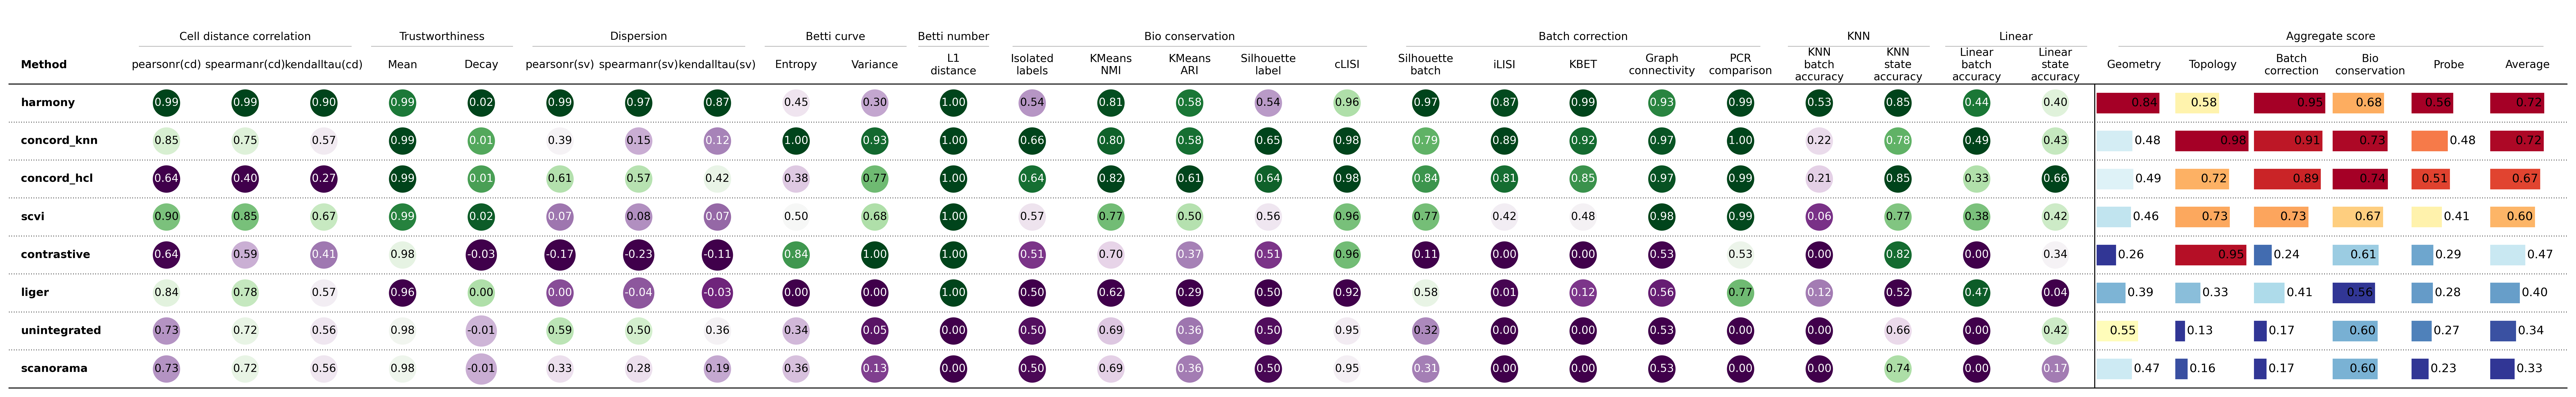

Cell distance correlation                               \
                         pearsonr(cd) spearmanr(cd) kendalltau(cd)   
harmony                      0.991096      0.987980       0.902829   
concord_knn                  0.851011      0.745729       0.565799   
concord_hcl                  0.637057      0.404250       0.274466   
scvi                         0.904048      0.846785       0.672155   
contrastive                  0.641104      0.591907       0.411865   

            Trustworthiness             Dispersion                \
                       Mean     Decay pearsonr(sv) spearmanr(sv)   
harmony            0.990102  0.019172     0.986424      0.966923   
concord_knn        0.993957  0.010783     0.393150      0.149231   
concord_hcl        0.994140  0.011422     0.610122      0.568462   
scvi               0.989462  0.017005     0.074285      0.081538   
contrastive        0.976752 -0.025517    -0.172951     -0.232308   

                           Betti curve            ...             KNN  \
            kendalltau(sv)     Entropy  Variance  ... batch\naccuracy   
harmony           0.866667    0.445887  0.304086  ...           0.535   
concord_knn       0.120000    1.000000  0.927834  ...           0.225   
concord_hcl       0.420000    0.376563  0.772762  ...           0.210   
scvi              0.073333    0.501051  0.682946  ...           0.060   
contrastive      -0.113333    0.842001  1.000000  ...           0.000   

                                     Linear                 Aggregate score  \
            state\naccuracy batch\naccuracy state\naccuracy        Geometry   
harmony               0.850           0.445           0.395        0.838899   
concord_knn           0.780           0.495           0.435        0.478707   
concord_hcl           0.850           0.335           0.660        0.489990   
scvi                  0.765           0.375           0.425        0.457327   
contrastive           0.825           0.000           0.340        0.259690   

                                                                            
             Topology Batch correction Bio conservation    Probe   Average  
harmony      0.583324         0.951234         0.684754  0.55625  0.722892  
concord_knn  0.975945         0.911734         0.732849  0.48375  0.716597  
concord_hcl  0.716442         0.891487          0.73593  0.51375   0.66952  
scvi         0.727999         0.726184         0.673399  0.40625  0.598232  
contrastive  0.947334         0.235249         0.610742  0.29125  0.468853  

[5 rows x 31 columns]

In [18]:
combined_keys = [
        "unintegrated",
        "scanorama", "liger", "harmony",
        "scvi", 
        "concord_knn", "concord_hcl", "contrastive"
    ]
out = ccd.bm.run_benchmark_pipeline(
    adata,
    embedding_keys=combined_keys,
    state_key="leiden_no_noise",
    batch_key="batch",
    groundtruth_key="no_noise",  # use the Leiden clusters as ground truth
    save_dir=save_dir / "benchmarks_out",
    file_suffix=file_suffix,  # e.g. "2025-06-25"
    run=("scib", "probe", "geometry", "topology"),          # run only these blocks
    plot_individual=False,          # skip the intermediate PDFs
)
combined = out["combined"]
combined.head()

### Plotting

In [45]:
import pickle
with open('../save/dev_simulation_trajectory-Jun26/benchmarks_out/topology_diagrams_Jun26-1103.pkl', 'rb') as f:
    diagrams = pickle.load(f)

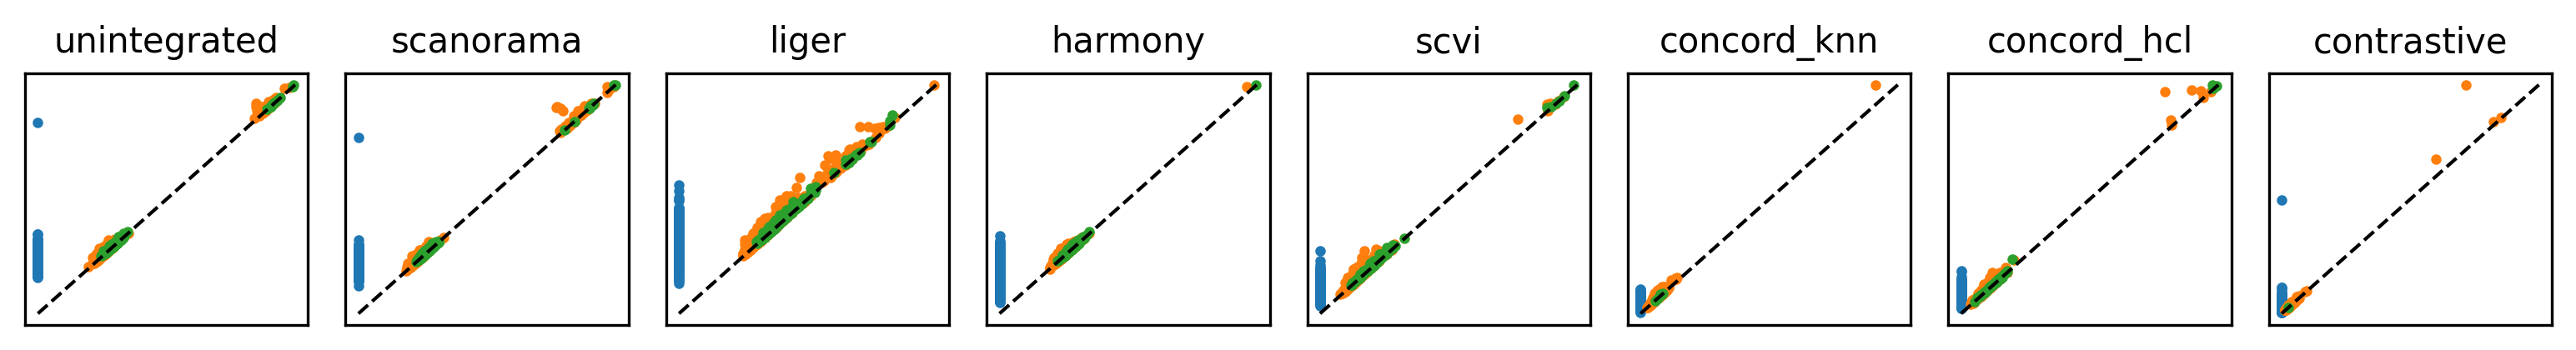

In [46]:
# Reorder diagrams with the same order as the combined keys
diagrams_ordered = {key: diagrams[key] for key in combined_keys}
ccd.pl.plot_persistence_diagrams(diagrams_ordered, base_size=(1.3, 1.5), dpi=300, marker_size=4, n_cols=len(diagrams_ordered), fontsize=10, save_path=save_dir / f"persistence_diagrams_{file_suffix}.pdf", legend=False, label_axes=False, axis_ticks=False)

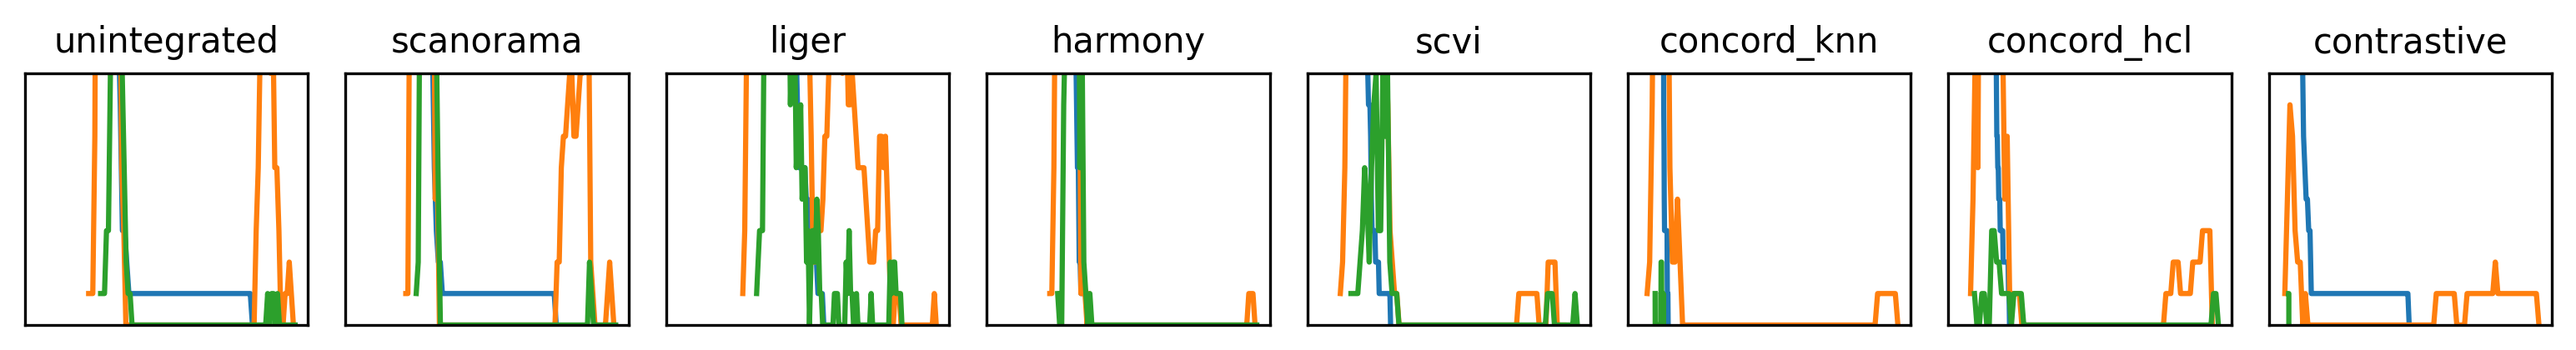

In [47]:
ccd.pl.plot_betti_curves(diagrams_ordered, nbins=100, base_size=(1.3, 1.5), n_cols=len(diagrams_ordered), fontsize=10, save_path=save_dir / f"betti_curves_{file_suffix}.pdf", dpi=300, legend=False, label_axes=False, axis_ticks=False)

In [50]:
geometry_full = pickle.load(open(Path("../save/dev_simulation_trajectory-Jun26/benchmarks_out/geometry_results_Jun26-1103.pkl"), "rb"))

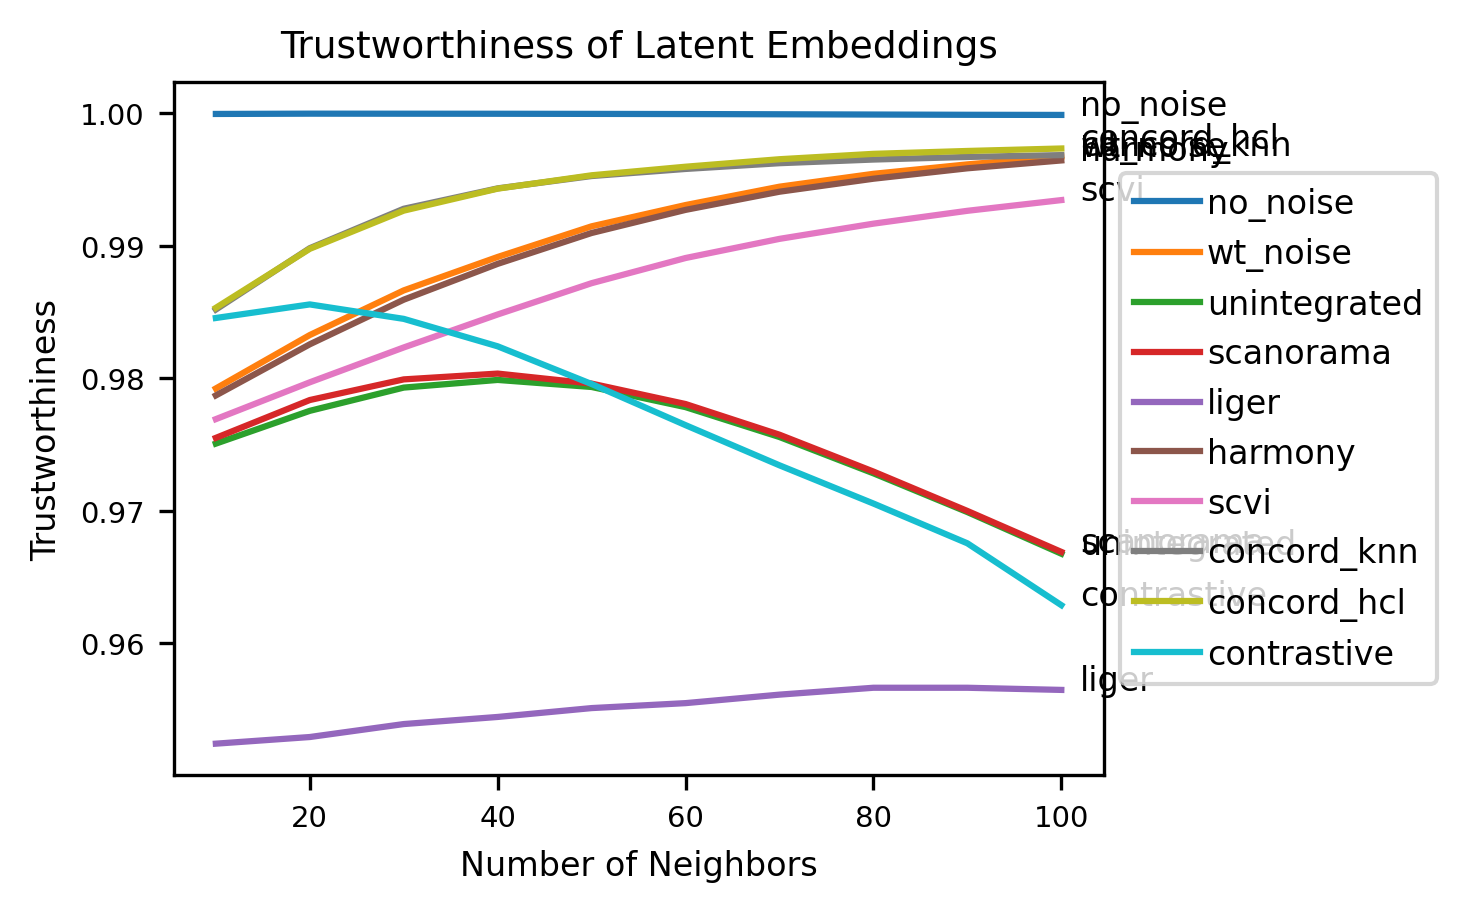

In [52]:
trustworthiness_scores = geometry_full['trustworthiness']['scores']
ccd.pl.plot_trustworthiness(trustworthiness_scores, text_shift=2, legend=True, save_path=save_dir / f"trustworthiness_{file_suffix}.pdf", figsize=(4,3))